# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [20]:
## Setup and Installation
# Install required packages
# %pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import string 

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

NumPy Training data shape: (88800, 28, 28, 1)
NumPy Test data shape: (14800, 28, 28, 1)
Number of classes: 26


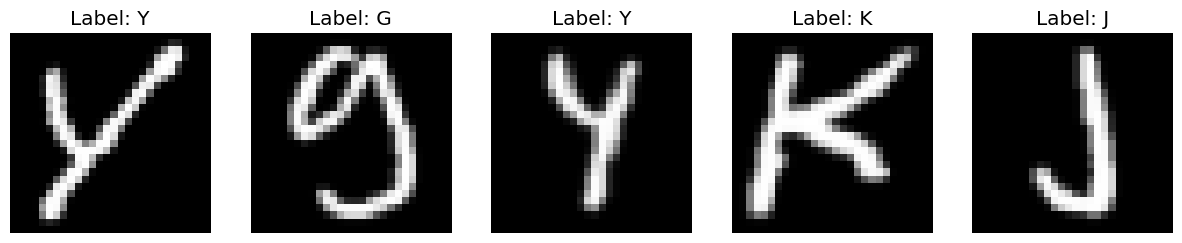

In [21]:
# Load EMNIST dataset using TensorFlow Datasets
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Convert tf.data.Dataset to NumPy arrays
def convert_to_numpy(ds):
    x = []
    y = []
    for image, label in tfds.as_numpy(ds):
        x.append(image)
        y.append(label)
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train_np, y_train_np = convert_to_numpy(ds_train)
x_test_np, y_test_np = convert_to_numpy(ds_test)

# Print basic dataset information (NumPy shapes)
print(f"NumPy Training data shape: {x_train_np.shape}")
print(f"NumPy Test data shape: {x_test_np.shape}")
print(f"Number of classes: {len(np.unique(y_train_np))}")

# Plot sample images (using NumPy arrays)
alphabet = string.ascii_uppercase + string.ascii_lowercase
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_np[i].squeeze().T, cmap='gray')
    plt.title(f'Label: {alphabet[y_train_np[i] - 1]}')
    plt.axis('off')
plt.show()

In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np # Ensure numpy is imported here

# Preprocessing for PyTorch
x_train_np_squeezed = x_train_np.squeeze(-1) # Remove the last dimension if it's 1
x_test_np_squeezed = x_test_np.squeeze(-1)

x_train_pt = torch.tensor(x_train_np_squeezed, dtype=torch.float32).unsqueeze(1) / 255.0
x_test_pt = torch.tensor(x_test_np_squeezed, dtype=torch.float32).unsqueeze(1) / 255.0
y_train_pt = torch.tensor(y_train_np - 1, dtype=torch.long)
y_test_pt = torch.tensor(y_test_np - 1, dtype=torch.long)

# Split into train and validation sets
x_train_pt, x_val_pt, y_train_pt, y_val_pt = train_test_split(
    x_train_pt, y_train_pt, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(x_train_pt, y_train_pt)
val_dataset = TensorDataset(x_val_pt, y_val_pt)
test_dataset = TensorDataset(x_test_pt, y_test_pt)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("PyTorch DataLoaders created.")
print(f"PyTorch Training data shape for loader: {next(iter(train_loader))[0].shape}")
print(f"PyTorch Validation data shape for loader: {next(iter(val_loader))[0].shape}")
print(f"PyTorch Test data shape for loader: {next(iter(test_loader))[0].shape}")

PyTorch DataLoaders created.
PyTorch Training data shape for loader: torch.Size([32, 1, 28, 28])
PyTorch Validation data shape for loader: torch.Size([32, 1, 28, 28])
PyTorch Test data shape for loader: torch.Size([32, 1, 28, 28])


## 2. Model Implementation

### TensorFlow/Keras Implementation

In [24]:
# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.

    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss

    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate

    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)

    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),

        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Optional third conv layer (improves performance)
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),

        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and compile model
input_shape = (28, 28, 1)
num_classes = 26
keras_cnn_model = create_cnn_keras(input_shape, num_classes)
keras_cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,866 (3.43 MB)

 Trainable params: 899,418 (3.43 MB)

 Non-trainable params: 448 (1.75 KB)

### PyTorch Implementation

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.

        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization

        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate

        Args:
            num_classes: Number of output classes (26 for letters)
        """
        super(CNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Optional third convolutional block (can improve performance)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 128) # Assuming 28x28 input
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # First convolutional block
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Optional third convolutional block
        x = self.conv3(x)
        x = F.relu(self.bn3(x))

        # Flatten for fully connected layers
        x = torch.flatten(x, 1) # More robust way to flatten

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# Create model
pytorch_cnn_model = CNN(num_classes=26)
print(pytorch_cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


## 3. Training and Evaluation

### TensorFlow/Keras Training

In [ ]:
### TensorFlow/Keras Training

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history_keras = keras_cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history_keras.history['accuracy'], label='Training')
ax1.plot(history_keras.history['val_accuracy'], label='Validation')
ax1.set_title('Keras Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history_keras.history['loss'], label='Training')
ax2.plot(history_keras.history['val_loss'], label='Validation')
ax2.set_title('Keras Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
loss_keras, accuracy_keras = keras_cnn_model.evaluate(x_test, y_test, verbose=0)
print(f'Keras Test Loss: {loss_keras:.4f}')
print(f'Keras Test Accuracy: {accuracy_keras:.4f}')

# Make predictions on the test set
y_pred_keras = keras_cnn_model.predict(x_test)
y_pred_classes_keras = np.argmax(y_pred_keras, axis=1)
y_true_classes_keras = np.argmax(y_test, axis=1)

# Calculate and print metrics
print("\nKeras Classification Metrics:")
print(f"Accuracy: {accuracy_score(y_true_classes_keras, y_pred_classes_keras):.4f}")
print(f"Precision (macro): {precision_score(y_true_classes_keras, y_pred_classes_keras, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true_classes_keras, y_pred_classes_keras, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_true_classes_keras, y_pred_classes_keras, average='macro'):.4f}")

# Plot confusion matrix
cm_keras = confusion_matrix(y_true_classes_keras, y_pred_classes_keras)
plt.figure(figsize=(15, 15))
sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues',
            xticklabels=alphabet, yticklabels=alphabet)
plt.title('Keras Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save model and metrics
keras_metrics = {
    'test_loss': loss_keras,
    'test_accuracy': accuracy_keras,
    'accuracy': accuracy_score(y_true_classes_keras, y_pred_classes_keras),
    'precision_macro': precision_score(y_true_classes_keras, y_pred_classes_keras, average='macro'),
    'recall_macro': recall_score(y_true_classes_keras, y_pred_classes_keras, average='macro'),
    'f1_macro': f1_score(y_true_classes_keras, y_pred_classes_keras, average='macro')
}

import json
with open('results/part_2/keras_metrics.json', 'w') as f:
    json.dump(keras_metrics, f)

print("\nKeras model and metrics saved.")

### PyTorch Training

In [26]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = pytorch_cnn_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
epochs = 20
history_pytorch = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss_pytorch = float('inf')
patience_pytorch = 5
patience_counter_pytorch = 0

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total

    # Save history
    history_pytorch['train_loss'].append(train_loss)
    history_pytorch['train_acc'].append(train_acc)
    history_pytorch['val_loss'].append(val_loss)
    history_pytorch['val_acc'].append(val_acc)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early stopping
    if val_loss < best_val_loss_pytorch:
        best_val_loss_pytorch = val_loss
        patience_counter_pytorch = 0
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
    else:
        patience_counter_pytorch += 1
        if patience_counter_pytorch >= patience_pytorch:
            print("PyTorch Early stopping triggered")
            break

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history_pytorch['train_acc'], label='Training')
ax1.plot(history_pytorch['val_acc'], label='Validation')
ax1.set_title('PyTorch Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history_pytorch['train_loss'], label='Training')
ax2.plot(history_pytorch['val_loss'], label='Validation')
ax2.set_title('PyTorch Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluation on the test set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_correct / test_total
print(f'PyTorch Test Loss: {test_loss:.4f}')
print(f'PyTorch Test Accuracy: {test_acc:.4f}')

# Calculate and print metrics
print("\nPyTorch Classification Metrics:")
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision (macro): {precision_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(all_labels, all_preds, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(all_labels, all_preds, average='macro'):.4f}")

# Plot confusion matrix
cm_pytorch = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='viridis',
            xticklabels=alphabet, yticklabels=alphabet)
plt.title('PyTorch Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save model and metrics
pytorch_metrics = {
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'accuracy': accuracy_score(all_labels, all_preds),
    'precision_macro': precision_score(all_labels, all_preds, average='macro'),
    'recall_macro': recall_score(all_labels, all_preds, average='macro'),
    'f1_macro': f1_score(all_labels, all_preds, average='macro')
}

import json
with open('results/part_2/pytorch_metrics.json', 'w') as f:
    json.dump(pytorch_metrics, f)

print("\nPyTorch model and metrics saved.")

Epoch [1/20], Train Loss: 1.1132, Train Acc: 0.6407, Val Loss: 0.3332, Val Acc: 0.8912


KeyboardInterrupt: 

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for CNN input
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create CNN with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in CNN layers
   - Solution: Ensure data is properly shaped (samples, height, width, channels)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters